In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import tensorflow as tf
import pickle
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [3]:
ResNet50_MODEL=tf.keras.applications.ResNet50(input_shape=(224,224,3),
                                               include_top=False,
                                               weights="imagenet")

In [4]:
len(ResNet50_MODEL.layers)

175

In [5]:
ResNet50_MODEL.layers[15].name

'conv2_block1_0_bn'

In [6]:
for layer in ResNet50_MODEL.layers:
    layer.trainable=True

In [7]:
ResNet50_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [8]:
batch_size = 64
l1_factor = 0.0001
l2_factor = 0.001
dropout = 0.5
learning_rate = 0.0001
target_size_image_shape = (224, 224)

In [9]:
model=tf.keras.models.Sequential([
                                  ResNet50_MODEL,
                                  tf.keras.layers.GlobalAveragePooling2D(),
                                  tf.keras.layers.Dropout(dropout, name='Dropout_Regularization1'),
                                  tf.keras.layers.Dense(4908, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
Dropout_Regularization1 (Dro (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4908)              10056492  
Total params: 33,644,204
Trainable params: 33,591,084
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
train_data_dir = '../datasets/group5_set_224/set_224/train/'
valid_data_dir = '../datasets/group5_set_224/set_224/valid/'

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1.0/255)

In [12]:
#flow training images
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 107289 images belonging to 4908 classes.


In [13]:
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    target_size=target_size_image_shape,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

Found 29448 images belonging to 4908 classes.


### Save Labels in  Json file

In [14]:
indices_to_class_labels_dict = {value : key for key, value in train_generator.class_indices.items()}
print(len(indices_to_class_labels_dict))
print(indices_to_class_labels_dict)
with open("group5_indices_to_class_labels_dict.json", "wb") as pickle_file:
    pickle.dump(indices_to_class_labels_dict, pickle_file)

4908
{0: '100015', 1: '100039', 2: '100084', 3: '100119', 4: '100125', 5: '100152', 6: '100166', 7: '100194', 8: '100349', 9: '100437', 10: '100441', 11: '100458', 12: '100463', 13: '100541', 14: '100582', 15: '100608', 16: '100638', 17: '100640', 18: '100655', 19: '100663', 20: '100702', 21: '10073', 22: '100737', 23: '100774', 24: '100788', 25: '100802', 26: '100805', 27: '100849', 28: '10087', 29: '100871', 30: '101', 31: '101007', 32: '101014', 33: '101032', 34: '101044', 35: '101051', 36: '101075', 37: '10111', 38: '101165', 39: '101204', 40: '10121', 41: '101224', 42: '101242', 43: '101247', 44: '10128', 45: '101379', 46: '10139', 47: '101393', 48: '101479', 49: '101488', 50: '10149', 51: '101568', 52: '101618', 53: '101621', 54: '101706', 55: '101716', 56: '101732', 57: '101759', 58: '101963', 59: '101979', 60: '102052', 61: '102072', 62: '102134', 63: '102205', 64: '102262', 65: '102292', 66: '102301', 67: '102356', 68: '102400', 69: '102420', 70: '102489', 71: '102499', 72: '1

### Callbacks and Fitting Modeling

In [15]:
outputFolder = 'checkpoints_group5'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
checkpoint_filepath=outputFolder+"/model-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_acc', verbose=1, mode='max',
    save_best_only=True, save_weights_only=True,
    save_frequency='epoch')

In [ ]:
# history = model.fit_generator(
#     generator = train_generator,
#     steps_per_epoch = train_generator.n // batch_size,
#     validation_data = valid_generator,
#     validation_steps = valid_generator.n // batch_size,
#     callbacks=[checkpoint_callback],
#     epochs = 100,
#     workers = 8,
#     verbose=1
# )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
1676/1676 [==============================] - ETA: 0s - loss: 8.0837 - acc: 0.0051
Epoch 00001: val_acc improved from -inf to 0.04786, saving model to checkpoints_group5/model-01-0.05.hdf5
1676/1676 [==============================] - 524s 312ms/step - loss: 8.0837 - acc: 0.0051 - val_loss: 6.5714 - val_acc: 0.0479
Epoch 2/100
1676/1676 [==============================] - ETA: 0s - loss: 5.6105 - acc: 0.1219
Epoch 00002: val_acc improved from 0.04786 to 0.23588, saving model to checkpoints_group5/model-02-0.24.hdf5
1676/1676 [==============================] - 527s 315ms/step - loss: 5.6105 - acc: 0.1219 - val_loss: 4.7763 - val_acc: 0.2359
Epoch 3/100
1676/1676 [==============================] - ETA: 0s - loss: 4.0996 - acc: 0.2832
Epoch 00003: val_acc improved from 0.23588 to 0.34127, saving model to checkpoints_group5/model-03-0.34.hdf5
1676/1676 [==============================] - 528s 315ms/step - l

In [17]:
# model.load_weights("checkpoints_group5/model-23-0.56.hdf5")

In [ ]:
# history = model.fit_generator(
#     generator = train_generator,
#     steps_per_epoch = train_generator.n // batch_size,
#     validation_data = valid_generator,
#     validation_steps = valid_generator.n // batch_size,
#     callbacks=[checkpoint_callback],
#     epochs = 76,
#     workers = 8,
#     verbose=1
# )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/76
1676/1676 [==============================] - ETA: 0s - loss: 0.4141 - acc: 0.8877
Epoch 00001: val_acc improved from -inf to 0.50751, saving model to checkpoints_group5/model-01-0.51.hdf5
1676/1676 [==============================] - 525s 313ms/step - loss: 0.4141 - acc: 0.8877 - val_loss: 4.0620 - val_acc: 0.5075
Epoch 2/76
1676/1676 [==============================] - ETA: 0s - loss: 0.3599 - acc: 0.9022
Epoch 00002: val_acc improved from 0.50751 to 0.52498, saving model to checkpoints_group5/model-02-0.52.hdf5
1676/1676 [==============================] - 530s 316ms/step - loss: 0.3599 - acc: 0.9022 - val_loss: 3.9398 - val_acc: 0.5250
Epoch 3/76
1676/1676 [==============================] - ETA: 0s - loss: 0.3367 - acc: 0.9096
Epoch 00003: val_acc improved from 0.52498 to 0.55030, saving model to checkpoints_group5/model-03-0.55.hdf5
1676/1676 [==============================] - 530s 316ms/step - loss

In [17]:
model.load_weights("checkpoints_group5/model-08-0.56.hdf5")

In [18]:
history = model.fit_generator(
    generator = train_generator,
    steps_per_epoch = train_generator.n // batch_size,
    validation_data = valid_generator,
    validation_steps = valid_generator.n // batch_size,
    callbacks=[checkpoint_callback],
    epochs = 50,
    workers = 4,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1676/1676 [==============================] - ETA: 0s - loss: 0.2695 - acc: 0.9264
Epoch 00001: val_acc improved from -inf to 0.51872, saving model to checkpoints_group5/model-01-0.52.hdf5
1676/1676 [==============================] - 521s 311ms/step - loss: 0.2695 - acc: 0.9264 - val_loss: 4.4058 - val_acc: 0.5187
Epoch 2/50
1676/1676 [==============================] - ETA: 0s - loss: 0.2353 - acc: 0.9355
Epoch 00002: val_acc improved from 0.51872 to 0.55649, saving model to checkpoints_group5/model-02-0.56.hdf5
1676/1676 [==============================] - 524s 313ms/step - loss: 0.2353 - acc: 0.9355 - val_loss: 4.0190 - val_acc: 0.5565
Epoch 3/50
1676/1676 [==============================] - ETA: 0s - loss: 0.2286 - acc: 0.9370
Epoch 00003: val_acc did not improve from 0.55649
1676/1676 [==============================] - 525s 313ms/step - loss: 0.2286 - acc: 0.9370 - val_loss: 4.2318 - val_acc: 0.5184

Epoch 29/50
1676/1676 [==============================] - ETA: 0s - loss: 0.1098 - acc: 0.9700
Epoch 00029: val_acc did not improve from 0.57473
1676/1676 [==============================] - 524s 313ms/step - loss: 0.1098 - acc: 0.9700 - val_loss: 4.5453 - val_acc: 0.5510
Epoch 30/50
1676/1676 [==============================] - ETA: 0s - loss: 0.1118 - acc: 0.9685
Epoch 00030: val_acc did not improve from 0.57473
1676/1676 [==============================] - 524s 313ms/step - loss: 0.1118 - acc: 0.9685 - val_loss: 4.4129 - val_acc: 0.5672
Epoch 31/50
1676/1676 [==============================] - ETA: 0s - loss: 0.1010 - acc: 0.9722
Epoch 00031: val_acc did not improve from 0.57473
1676/1676 [==============================] - 524s 313ms/step - loss: 0.1010 - acc: 0.9722 - val_loss: 4.4251 - val_acc: 0.5669
Epoch 32/50
1676/1676 [==============================] - ETA: 0s - loss: 0.1042 - acc: 0.9702
Epoch 00032: val_acc did not improve from 0.57473
1676/1676 [==============================] 

<Figure size 432x288 with 0 Axes>

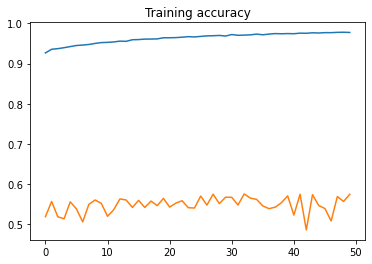

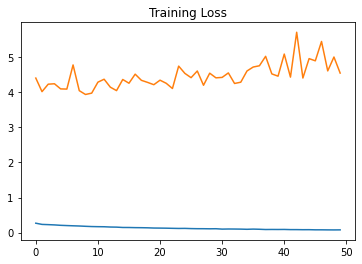

<Figure size 432x288 with 0 Axes>

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training Loss')
plt.figure()

In [ ]:
gsedrfgdffg